In [1]:
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(rc={"figure.figsize": (15, 4)})
sns.set_context('talk')

In [2]:
# Build spark session
import findspark
findspark.init('/usr/hdp/current/spark2-client')
# Build the SparkSession
from pyspark.sql import SparkSession

# Initialize Hive metastore
spark = SparkSession.builder \
    .master("local") \
    .appName("DF2HIVE") \
    .enableHiveSupport() \
    .config("spark.executor.memory", "1gb") \
    .getOrCreate()
sc = spark.sparkContext

from pyspark.sql import HiveContext
# Hive context
hc = HiveContext(sc)

In [3]:
table = 'guobiao_tsp_tbls.charging_full_soc'
vintypes = 'guobiao_tsp_tbls.vintypes'
min_counts = 4

query = 'SELECT jan.vin AS vin, (avg_ah_feb - avg_ah_jan)/avg_ah_feb * 100 AS ah_percent_diff,\
        avg_ah_jan, avg_ah_feb, avg_missing_time_jan, avg_missing_time_feb, \
        avg_min_temp_jan, avg_min_temp_feb, avg_max_temp_jan, avg_max_temp_feb, avg_avg_temp_jan, avg_avg_temp_feb FROM\
        (\
            SELECT vin, AVG(normalized_ah_throughput) as avg_ah_jan, AVG(missing_time) AS avg_missing_time_jan, \
            AVG(battery_temp_min) AS avg_min_temp_jan, \
            AVG(battery_temp_max) AS avg_max_temp_jan, \
            AVG(battery_temp_avg) AS avg_avg_temp_jan, \
            COUNT(missing_time) AS counts FROM \
            (\
                SELECT MONTH(day) AS month, vin, normalized_ah_throughput, battery_temp_min,  battery_temp_max, battery_temp_avg,\
                (duration - count_records / 360) / duration * 100 AS missing_time FROM {0}\
                WHERE vin in (SELECT vin FROM {1} WHERE vintype = \'A5HEV\') \
            ) a \
            WHERE month  == 1 \
            GROUP BY vin\
            HAVING counts > {2} \
        ) jan\
        JOIN\
        (\
            SELECT vin, AVG(normalized_ah_throughput) as avg_ah_feb, AVG(missing_time) AS avg_missing_time_feb, \
            AVG(battery_temp_min) AS avg_min_temp_feb, \
            AVG(battery_temp_max) AS avg_max_temp_feb, \
            AVG(battery_temp_avg) AS avg_avg_temp_feb, \
            COUNT(missing_time) AS counts FROM \
            (\
                SELECT MONTH(day) AS month, vin, normalized_ah_throughput, battery_temp_min, battery_temp_max, battery_temp_avg, \
                (duration - count_records / 360) / duration * 100 AS missing_time FROM {0}\
                WHERE vin in (SELECT vin FROM {1} WHERE vintype = \'A5HEV\') \
            ) a \
            WHERE month  == 2 \
            GROUP BY vin\
            HAVING counts > {2} \
        ) feb\
        ON jan.vin = feb.vin\
'.format(table, vintypes, min_counts)

spark_df = hc.sql("""{}""".format(query))
# Convert to pandas dataframe
df = spark_df.toPandas()

print('Read {} counts'.format(len(df)))
df.head()

Read 22 counts


,vin,ah_percent_diff,avg_ah_jan,avg_ah_feb,avg_missing_time_jan,avg_missing_time_feb,avg_min_temp_jan,avg_min_temp_feb,avg_max_temp_jan,avg_max_temp_feb,avg_avg_temp_jan,avg_avg_temp_feb
0,LMGHP1S5XH1S00056,3.294538,128.233763,132.602399,24.745103,-0.096514,10.000000,13.250000,26.600000,29.083333,40.222928,41.902767
1,LMGHP1S8XH1000661,-1.050415,120.412554,119.160871,10.588119,-0.075717,8.250000,7.777778,21.666667,22.111111,16.160016,16.757576
2,LMGHP1S8XH1000109,7.291506,110.191333,118.857862,19.275567,-0.007103,3.160000,8.200000,31.280000,30.600000,23.643493,23.793902
3,LMGHP1S59H1001127,1.513860,118.503957,120.325517,20.591809,0.177073,2.250000,6.800000,22.500000,19.800000,17.432278,15.850412
4,LMGHP1S84H1000039,-0.829434,118.582729,117.607255,28.459527,-0.138992,11.206897,10.000000,31.896552,34.250000,24.992793,27.096610


# Ah drop in January

/usr/lib64/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


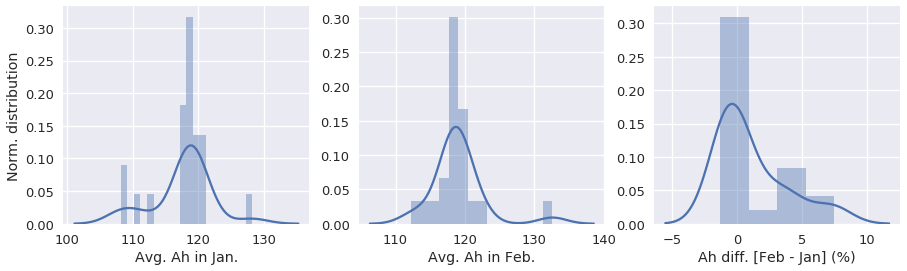

In [4]:
sns.set(rc={"figure.figsize": (15, 4)})
sns.set_context('talk')

fig, ax = plt.subplots(ncols=3, nrows=1)

sns.distplot(df['avg_ah_jan'], ax=ax[0])
ax[0].set_ylabel('Norm. distribution')
ax[0].set_xlabel('Avg. Ah in Jan.')
sns.distplot(df['avg_ah_feb'], ax=ax[1])
#ax[1].set_ylabel('Norm. distribution')
ax[1].set_xlabel('Avg. Ah in Feb.')
sns.distplot(df['ah_percent_diff'], ax=ax[2])
#ax[2].set_ylabel('Norm. distribution')
ax[2].set_xlabel('Ah diff. [Feb - Jan] (%)')
sns.despine()

# Missing time comparison    


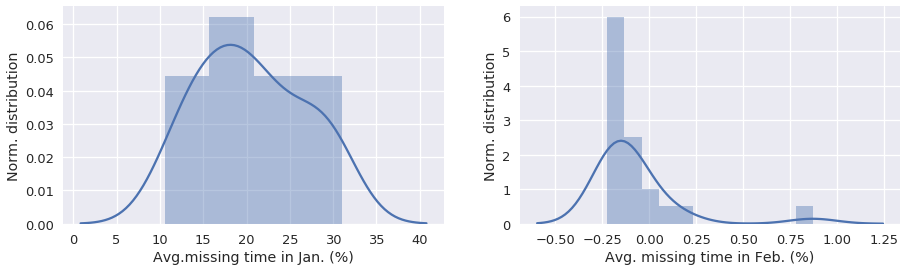

In [5]:
sns.set(rc={"figure.figsize": (15, 4)})
sns.set_context('talk')

fig, ax = plt.subplots(ncols=2, nrows=1)

sns.distplot(df['avg_missing_time_jan'], ax=ax[0])
ax[0].set_ylabel('Norm. distribution')
ax[0].set_xlabel('Avg.missing time in Jan. (%)')
sns.distplot(df['avg_missing_time_feb'], ax=ax[1])
ax[1].set_ylabel('Norm. distribution')
ax[1].set_xlabel('Avg. missing time in Feb. (%)')
sns.despine()

In January missing time is considerably larger than in February

# Minimum temperature comparison

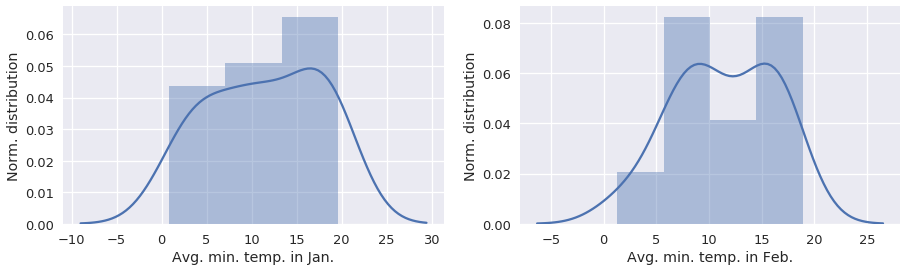

In [6]:
sns.set(rc={"figure.figsize": (15, 4)})
sns.set_context('talk')

fig, ax = plt.subplots(ncols=2, nrows=1)

sns.distplot(df['avg_min_temp_jan'], ax=ax[0])
ax[0].set_ylabel('Norm. distribution')
ax[0].set_xlabel('Avg. min. temp. in Jan.')
sns.distplot(df['avg_min_temp_feb'], ax=ax[1])
ax[1].set_ylabel('Norm. distribution')
ax[1].set_xlabel('Avg. min. temp. in Feb.')
sns.despine()

# Correlations

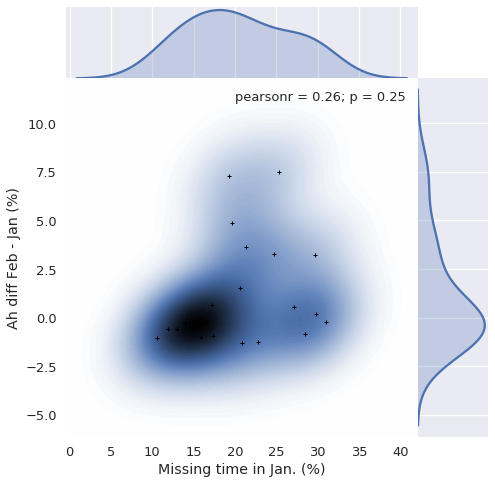

In [7]:
g = sns.jointplot(x='avg_missing_time_jan', y='ah_percent_diff', data=df, kind="kde", ratio=5, size=7, space=0, n_levels=100)
g.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+" )
g.set_axis_labels('Missing time in Jan. (%)', 'Ah diff Feb - Jan (%)')
sns.despine()

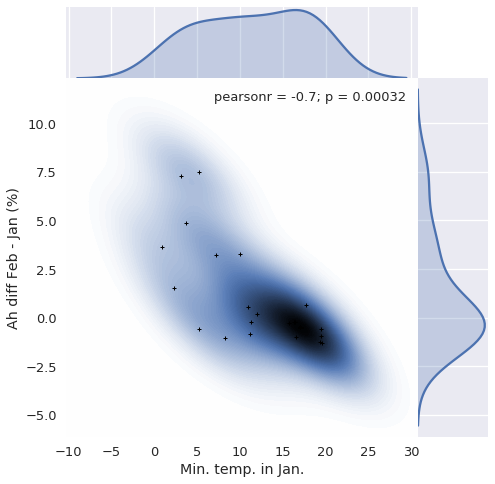

In [8]:
g = sns.jointplot(x='avg_min_temp_jan', y='ah_percent_diff', data=df, kind="kde", ratio=5, size=7, space=0, n_levels=100)
g.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+" )
g.set_axis_labels('Min. temp. in Jan.', 'Ah diff Feb - Jan (%)')
sns.despine()

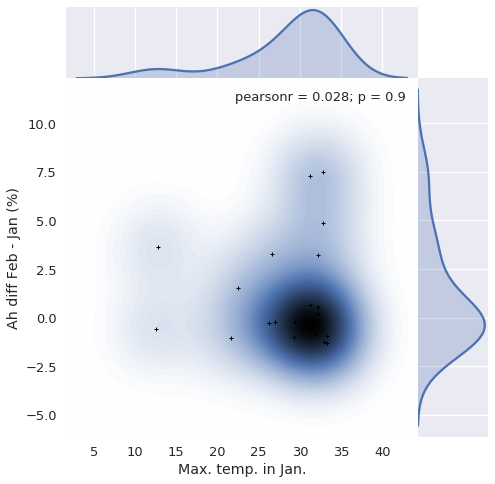

In [9]:
g = sns.jointplot(x='avg_max_temp_jan', y='ah_percent_diff', data=df, kind="kde", ratio=5, size=7, space=0, n_levels=100)
g.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+" )
g.set_axis_labels('Max. temp. in Jan.', 'Ah diff Feb - Jan (%)')
sns.despine()

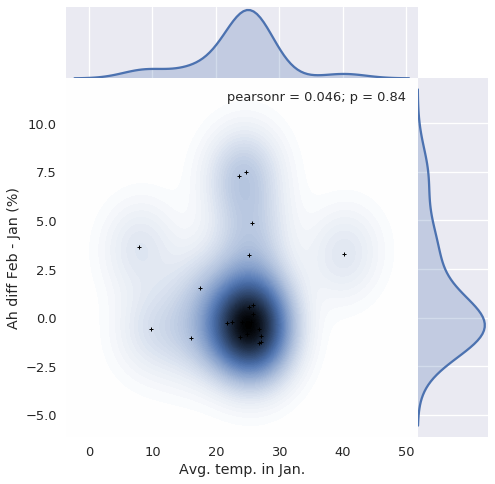

In [10]:
g = sns.jointplot(x='avg_avg_temp_jan', y='ah_percent_diff', data=df, kind="kde", ratio=5, size=7, space=0, n_levels=100)
g.plot_joint(plt.scatter, c="k", s=10, linewidth=1, marker="+" )
g.set_axis_labels('Avg. temp. in Jan.', 'Ah diff Feb - Jan (%)')
sns.despine()